Below is the code for our EMNLP2024 In Submission Paper: Automated Tone Transcription and Clustering with Tone2Vec.

This file contains all the experimental details presented in this paper. The official package will be released upon acceptance.

This is an anonymous version for review. Please do not distribute.

In [ ]:
import os
import math
import pickle
import torch
from torch import optim
from typing import List
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from random import sample

drive.mount('/content/drive')

Mounted at /content/drive


# **1.Tone2Vec**

In [ ]:
def tone_variation(seq1: List[int], seq2: List[int]) -> float:
    """
    Calculate the area between the pitch variation curves represented by seq1 and seq2.

    Args:
    - seq1 (List[int]): List of integers representing the first transcription, length 1-3.
    - seq2 (List[int]): List of integers representing the second transcription, length 1-3.

    Returns:
    - float: The area between the curves.
    """
    def get_curve(seq):
        if len(seq) == 1:
            # If the sequence length is 1, represent it as a horizontal line
            return lambda x: np.full_like(x, seq[0], dtype=np.float64)
        elif len(seq) == 2:
            # If the sequence length is 2, represent it as a line connecting (1, x1) and (3, x2)
            coeffs = np.polyfit([1, 3], seq, 1)
            return np.poly1d(coeffs)
        else:  # len(seq) == 3
            # If the sequence length is 3, use a quadratic curve fitting to represent pitch variations
            coeffs = np.polyfit([1, 2, 3], seq, 2)
            return np.poly1d(coeffs)

    # Compute the curves for both sequences
    curve1 = get_curve(seq1)
    curve2 = get_curve(seq2)

    # Define the function for the absolute difference between the two curves
    diff_curve = lambda x: np.abs(curve1(x) - curve2(x))

    # Use numerical integration (trapezoidal rule) to estimate the area between the curves
    x = np.linspace(1, 3, 1000)  # Sample 1000 points between 1 and 3
    y = diff_curve(x)
    area = np.trapz(y, x)  # Integrate using the trapezoidal rule

    return area


In [ ]:
#pre_computed all possible transcription

Simi_Quadratic = torch.zeros((6,6,6,6,6,6))

sequences = [[i, j, k] for i in range(6) for j in range(6) for k in range(6)]
non_zero_sequences = [seq for seq in sequences if any(seq)]

for idx1, seq1 in enumerate(non_zero_sequences):
    for idx2, seq2 in enumerate(non_zero_sequences):
        if idx1 <= idx2:
            trimmed_seq1 = [x for x in seq1 if x != 0]
            trimmed_seq2 = [x for x in seq2 if x != 0]
            similarity = tone_variation(trimmed_seq1, trimmed_seq2)
            i1, i2, i3 = seq1
            j1, j2, j3 = seq2
            Simi_Quadratic[i1, i2, i3, j1, j2, j3] = similarity
            Simi_Quadratic[j1, j2, j3, i1, i2, i3] = similarity

save_path = '.../emnlp_weights/transcription_variation.pt'
torch.save(Simi_Quadratic, save_path)

## **1.1 From Categories to Pitch-based Similarity Representations**

In [ ]:
dict_embed = {}

_seq = [[i, j, k] for i in range(1,6) for j in range(1,6) for k in range(1,6)]
_seq += [[i, j, 0] for i in range(1,6) for j in range(1,6)]
print(f"The Number of Tone Transcription is {len(_seq)}")

embed_matrix = np.zeros((len(_seq), len(_seq)))

The Number of Tone Transcription is 150


In [ ]:
for i in range(len(_seq)):
  for j in range(len(_seq)):
    embed_matrix[i,j] = Simi_Quadratic[_seq[i][0], _seq[i][1], _seq[i][2], _seq[j][0], _seq[j][1], _seq[j][2]]

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 9.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap
import umap

def reduce_dim(matrix: np.ndarray, dim: int = 2, method: str = 'pca') -> np.ndarray:
    """
    Reduce the dimensionality of the given matrix using the specified method.

    Args:
    - matrix (np.ndarray): Input matrix with shape [n_samples, n_features]
    - dim (int): Target dimensionality
    - method (str): Dimensionality reduction method ('pca', 'umap', 'tsne', 'mds', 'isomap')

    Returns:
    - np.ndarray: Reduced dimension matrix with shape [n_samples, dim]
    """
    if method == 'pca':
        reducer = PCA(n_components=dim)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=dim)
    elif method == 'tsne':
        reducer = TSNE(n_components=dim)
    elif method == 'mds':
        reducer = MDS(n_components=dim, dissimilarity='euclidean')
    elif method == 'isomap':
        reducer = Isomap(n_components=dim)
    else:
        raise ValueError(f"Unsupported method: {method}. Choose from 'pca', 'umap', 'tsne', 'mds', 'isomap'.")

    reduced_matrix = reducer.fit_transform(matrix)
    return reduced_matrix

In [ ]:
save_path = '.../EMNLP_Tone2Vec/weights/transcription_embedding.npy'
torch.save(embed_matrix, save_path)

## **1.2 Sino-Tibetan Languages Tone Variations**

In [ ]:
import pickle
import numpy as np

with open('.../EMNLP_Tone2Vec/weights/dialect_data.pkl', 'rb') as f:
    embdding_tone2vec = pickle.load(f)
    embedding_category = pickle.load(f)
    dialect_info = pickle.load(f)
    str_index = pickle.load(f)

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster

def perform_clustering(data, num_clusters=2, method='complete'):
    """
    Perform hierarchical clustering on the input data using various linkage methods.

    Args:
    - data (np.ndarray): Input data array with shape [num_samples, num_features].
    - num_clusters (int): Number of clusters to form.
    - method (str): Clustering method. One of 'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'.

    Returns:
    - list of lists: Each sublist contains indices of the samples in the corresponding cluster.
    """

    if method not in ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']:
        raise ValueError("Method must be one of 'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'")

    # Compute the linkage matrix
    linkage_matrix = linkage(data, method=method)

    # Form flat clusters
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    # Group the indices by cluster
    clusters = [[] for _ in range(num_clusters)]
    for idx, label in enumerate(cluster_labels):
        clusters[label - 1].append(idx)

    return clusters

In [ ]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
import numpy as np

def cluster_acc(golden_list, cluster_list):
    """
    Calculate the clustering accuracy by finding the best mapping between
    cluster assignments and golden standard labels.

    Args:
    - golden_list (List[List[int]]): List of lists where each sublist contains the indices of samples in the same golden standard cluster.
    - cluster_list (List[List[int]]): List of lists where each sublist contains the indices of samples in the same predicted cluster.

    Returns:
    - float: The accuracy of the clustering.
    """

    # Create a mapping from index to cluster id for golden labels
    golden_labels = np.zeros(sum(len(cluster) for cluster in golden_list), dtype=int)
    for cluster_id, indices in enumerate(golden_list):
        for idx in indices:
            golden_labels[idx] = cluster_id

    # Create a mapping from index to cluster id for predicted clusters
    pred_labels = np.zeros(sum(len(cluster) for cluster in cluster_list), dtype=int)
    for cluster_id, indices in enumerate(cluster_list):
        for idx in indices:
            pred_labels[idx] = cluster_id

    # Create the confusion matrix
    D = max(max(golden_labels), max(pred_labels)) + 1
    conf_matrix = np.zeros((D, D), dtype=int)
    for i in range(len(golden_labels)):
        conf_matrix[golden_labels[i], pred_labels[i]] += 1

    # Find the best mapping using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(conf_matrix.max() - conf_matrix)

    # Calculate the accuracy based on the best mapping
    accuracy = conf_matrix[row_ind, col_ind].sum() / len(golden_labels)
    return accuracy

In [ ]:
print(len(str_index['Huangxiao']), len(str_index['Hongchao']))

12 19


In [ ]:
# str_index

methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
golden_list = [str_index[key] for key in str_index.keys()]

tone2vec_acc, category_acc = [], []
tone2vec_cluster, category_cluster = [], []
for method in methods:
  clusters = perform_clustering(embdding_tone2vec, num_clusters=2, method=method)
  cluster_acc(golden_list, clusters)
  tone2vec_cluster.append(clusters)
  tone2vec_acc.append(cluster_acc(golden_list, clusters))
  # print(f"Method: {method}")
  # print(clusters)
  # break
tone2vec_acc

<ipython-input-10-f696ffe3b563>:22: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(data, method=method)


[0.6451612903225806,
 0.7096774193548387,
 0.7096774193548387,
 0.6451612903225806,
 0.7096774193548387,
 0.6129032258064516,
 0.8387096774193549]

In [ ]:
for method in methods:
  clusters = perform_clustering(embedding_category, num_clusters=2, method=method)
  cluster_acc(golden_list, clusters)
  category_cluster.append(clusters)
  category_acc.append(cluster_acc(golden_list, clusters))
  # print(f"Method: {method}")
  # print(clusters)
  # break
category_acc

<ipython-input-10-f696ffe3b563>:22: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(data, method=method)


[0.5806451612903226,
 0.6774193548387096,
 0.6774193548387096,
 0.7096774193548387,
 0.6129032258064516,
 0.6774193548387096,
 0.6129032258064516]

In [ ]:
pip install geopandas

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def location_allocate(dialect_info, cluster_indices, square_size=0.1, padding=0.01):
    """
    Allocate locations for each dialect area to avoid overlap and ensure a compact layout.

    Args:
    - dialect_info (pd.DataFrame): DataFrame containing 'eastLongitude' and 'northLatitude' columns.
    - cluster_indices (list of lists): List of lists, where each sublist contains indices of samples in the same cluster.
    - square_size (float): Size of each square in the plot.
    - padding (float): Padding between squares.

    Returns:
    - positions (dict): Dictionary mapping each index to its allocated position (left, right, bottom, top).
    """
    positions = {}

    # Get the range of longitudes and latitudes
    min_long, max_long = dialect_info['eastLongitude'].min(), dialect_info['eastLongitude'].max()
    min_lat, max_lat = dialect_info['northLatitude'].min(), dialect_info['northLatitude'].max()

    # Normalize longitudes and latitudes to the range 0 to 1
    norm_longs = (dialect_info['eastLongitude'] - min_long) / (max_long - min_long)
    norm_lats = (dialect_info['northLatitude'] - min_lat) / (max_lat - min_lat)

    # Sort to maintain relative positions
    sorted_indices = np.argsort(norm_longs + norm_lats)
    current_x, current_y = 0, 0

    for idx in sorted_indices:
        # Calculate the position of the square
        left = current_x
        right = left + square_size
        bottom = current_y
        top = bottom + square_size

        positions[idx] = (left, right, bottom, top)

        # Update current coordinates
        current_x += square_size + padding
        if current_x + square_size > 1:  # Move to the next row if the current row is full
            current_x = 0
            current_y += square_size + padding

    return positions

def plot_dialect_clusters(dialect_info, cluster_indices, square_size=0.1, padding=0.01):
    """
    Plot dialect clusters on a compact grid using squares for each location.

    Args:
    - dialect_info (pd.DataFrame): DataFrame containing 'eastLongitude' and 'northLatitude' columns.
    - cluster_indices (list of lists): List of lists, where each sublist contains indices of samples in the same cluster.
    - square_size (float): Size of each square in the plot.
    - padding (float): Padding between squares.

    Example:
    dialect_info = pd.DataFrame([
        {'point': '18E35', 'province': 'Jiangxi', 'city': 'Jiujiang', 'country': 'Ruichang', 'village': 'Pencheng Street',
         'area': 'Jianghuai Mandarin', 'slice': 'Huangxiao', 'slices': 'Unclear', 'eastLongitude': 115.408333,
         'northLatitude': 29.616667},
        # Add more example data...
    ])
    cluster_indices = [[0, 1, 2], [3, 4, 5]]  # Corresponding clustering results
    """
    # Get the position of each square
    positions = location_allocate(dialect_info, cluster_indices, square_size, padding)

    # Define fixed color mapping
    colors = ['red', 'blue']  # Colors for two clusters

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))

    # Draw squares for each cluster
    for cluster_id, indices in enumerate(cluster_indices):
        for idx in indices:
            left, right, bottom, top = positions[idx]
            color = colors[cluster_id % len(colors)]

            # Draw the square
            ax.fill_between([left, right], bottom, top, color=color, edgecolor='k')

    # Set plot title and labels
    ax.set_title('Dialect Clustering Grid')
    ax.set_xlabel('X Grid')
    ax.set_ylabel('Y Grid')

    # Beautify legend
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(cluster_indices))]
    labels = [f'Cluster {i + 1}' for i in range(len(cluster_indices))]
    ax.legend(handles, labels, title='Clusters', loc='upper right')

    plt.show()

In [ ]:
print(type(dialect_info[0]))
dialect_info_df = pd.DataFrame(dialect_info)

<class 'pandas.core.series.Series'>


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

def add_boundary_points(points, padding=0.1):
    """
    Add boundary points to the given set of points to create more diverse Voronoi regions.

    Args:
    - points (np.ndarray): Array of points (longitude, latitude).
    - padding (float): Padding added around the points to create boundary points.

    Returns:
    - np.ndarray: New set of points including boundary points.
    """
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    boundary_points = [
        [min_x - padding, min_y - padding],
        [min_x - padding, max_y + padding],
        [max_x + padding, min_y - padding],
        [max_x + padding, max_y + padding],
        [min_x - padding, (min_y + max_y) / 2],
        [max_x + padding, (min_y + max_y) / 2],
        [(min_x + max_x) / 2, min_y - padding],
        [(min_x + max_x) / 2, max_y + padding]
    ]

    return np.vstack([points, boundary_points])

def plot_voronoi_clusters(dialect_info, cluster_indices, padding=0.1):
    """
    Plot dialect clusters using Voronoi diagram.

    Args:
    - dialect_info (pd.DataFrame): DataFrame containing 'eastLongitude' and 'northLatitude' columns.
    - cluster_indices (list of lists): List of lists, where each sublist contains indices of samples in the same cluster.

    Example:
    dialect_info = pd.DataFrame([
        {'point': '18E35', 'province': 'Jiangxi', 'city': 'Jiujiang', 'country': 'Ruichang', 'village': 'Pencheng Street',
         'area': 'Jianghuai Mandarin', 'slice': 'Huangxiao', 'slices': 'Unclear', 'eastLongitude': 115.408333,
         'northLatitude': 29.616667},
        # Add more example data...
    ])
    cluster_indices = [[0, 1, 2], [3, 4, 5]]  # Corresponding clustering results
    """
    # Extract longitude and latitude information
    points = dialect_info[['eastLongitude', 'northLatitude']].values

    # Add boundary points
    points_with_boundary = add_boundary_points(points, padding=padding)

    # Generate Voronoi diagram
    vor = Voronoi(points_with_boundary)

    # Define color mapping
    colors = ['red', 'blue']  # Colors for two clusters

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal')

    # Plot Voronoi diagram
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_colors='k', line_width=1, line_alpha=0.6)

    # Fill each cluster with color
    for cluster_id, indices in enumerate(cluster_indices):
        for idx in indices:
            region_index = vor.point_region[idx]
            vertices = vor.regions[region_index]
            if -1 not in vertices:  # Ignore points at infinity
                polygon = [vor.vertices[i] for i in vertices]
                color = colors[cluster_id % len(colors)]
                ax.fill(*zip(*polygon), color=color, alpha=0.5)

    # Set plot title and labels
    ax.set_title('Dialect Clustering Voronoi Diagram')

    # Hide axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

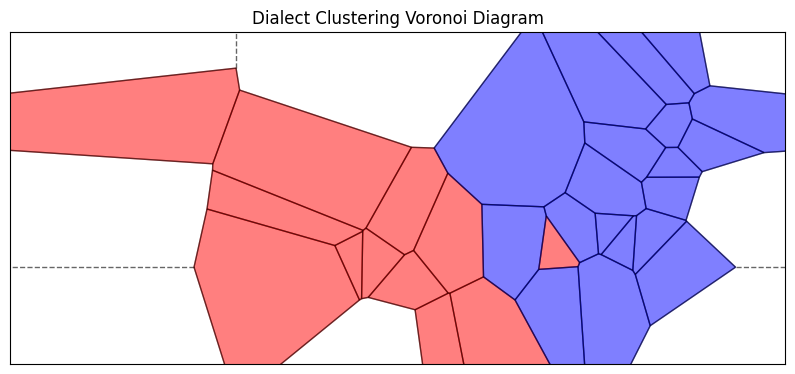

In [ ]:
# dialect_info

# plot_dialect_clusters(dialect_info_df, golden_list, square_size=0.5)
plot_voronoi_clusters(dialect_info_df, golden_list)

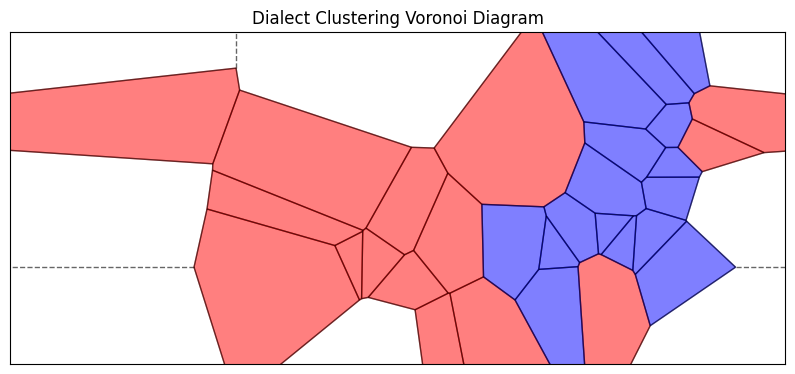

In [ ]:
list_ = [tone2vec_cluster[-1][1], tone2vec_cluster[-1][0]]
plot_voronoi_clusters(dialect_info_df, list_)

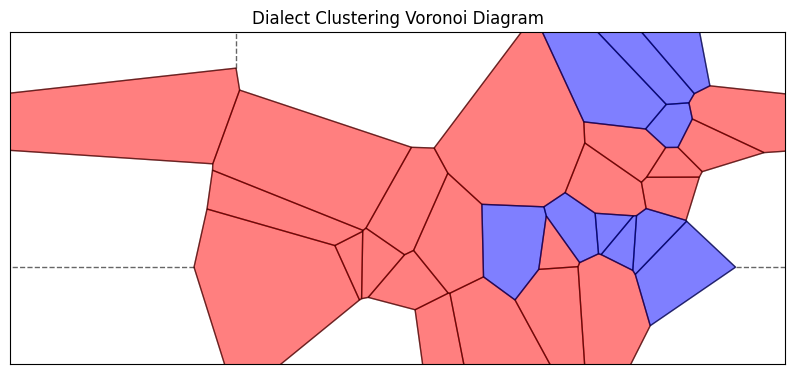

In [ ]:
list_ = [category_cluster[3][0], category_cluster[3][1]]
plot_voronoi_clusters(dialect_info_df, list_)

In [ ]:
# MDS code

import numpy as np
from sklearn.manifold import MDS

# Assuming embdding_tone2vec and embedding_category are already defined numpy arrays
# Example:
# embdding_tone2vec = np.random.rand(100, 50)  # Example matrix with 100 samples and 50 features
# embedding_category = np.random.rand(100, 50)  # Example matrix with 100 samples and 50 features

# Initialize MDS with 1 component
mds = MDS(n_components=1, random_state=609)

# Apply MDS to embdding_tone2vec
tone2vec_1d = mds.fit_transform(embdding_tone2vec)

# Apply MDS to embedding_category
category_1d = mds.fit_transform(embedding_category)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalize

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.manifold import MDS


def plot_voronoi_with_gradient(dialect_info, embedding, padding=0.1):
    """
    Plot dialect areas using Voronoi diagram with gradient colors based on one-dimensional features.

    Args:
    - dialect_info (pd.DataFrame): DataFrame containing 'eastLongitude' and 'northLatitude' columns.
    - embedding (np.ndarray): One-dimensional array with feature values for each dialect area.

    Example:
    dialect_info = pd.DataFrame([
        {'point': '18E35', 'province': '江西', 'city': '九江', 'country': '瑞昌', 'village': '湓城街道',
         'area': '江淮官话', 'slice': '黄孝片', 'slices': '系属不明', 'eastLongitude': 115.408333,
         'northLatitude': 29.616667},
        # Add more example data...
    ])
    embedding = np.random.rand(len(dialect_info))  # Example embedding
    """
    # Apply MDS to reduce dimensionality to one dimension
    mds = MDS(n_components=1, random_state=42)
    reduced_embedding = mds.fit_transform(embedding.reshape(-1, 1)).flatten()

    # Normalize the reduced embedding for color mapping
    norm = plt.Normalize(reduced_embedding.min(), reduced_embedding.max())
    cmap = plt.cm.RdBu  # Red to Blue colormap

    # Extract longitude and latitude
    points = dialect_info[['eastLongitude', 'northLatitude']].values

    # Add boundary points
    points_with_boundary = add_boundary_points(points, padding=padding)

    # Generate Voronoi diagram
    vor = Voronoi(points_with_boundary)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal')

    # Plot Voronoi diagram
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_colors='k', line_width=1, line_alpha=0.6)

    # Fill regions with gradient colors based on reduced embedding values
    for idx, point in enumerate(points):
        region_index = vor.point_region[idx]
        vertices = vor.regions[region_index]
        if -1 not in vertices:  # Ignore regions with vertices at infinity
            polygon = [vor.vertices[i] for i in vertices]
            color = cmap(norm(reduced_embedding[idx]))
            ax.fill(*zip(*polygon), color=color, edgecolor='k', alpha=0.7)

    # Set plot title
    ax.set_title('Dialect Areas with Gradient Colors Based on One-Dimensional Features')

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Feature Value')

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.manifold import MDS
from matplotlib.colors import LinearSegmentedColormap

def add_boundary_points(points, padding=0.1):
    """
    Add boundary points to the given set of points to create more diverse Voronoi regions.

    Args:
    - points (np.ndarray): Array of points (longitude, latitude).
    - padding (float): Padding added around the points to create boundary points.

    Returns:
    - np.ndarray: New set of points including boundary points.
    """
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    boundary_points = [
        [min_x - padding, min_y - padding],
        [min_x - padding, max_y + padding],
        [max_x + padding, min_y - padding],
        [max_x + padding, max_y + padding],
        [min_x - padding, (min_y + max_y) / 2],
        [max_x + padding, (min_y + max_y) / 2],
        [(min_x + max_x) / 2, min_y - padding],
        [(min_x + max_x) / 2, max_y + padding]
    ]

    return np.vstack([points, boundary_points])

def create_custom_colormap():
    """
    Create a custom colormap from light blue to dark blue.

    Returns:
    - LinearSegmentedColormap: Custom colormap.
    """
    cdict = {
        'red':   [(0.0, 0.9, 0.9),
                  (1.0, 0.0, 0.0)],
        'green': [(0.0, 0.9, 0.9),
                  (1.0, 0.0, 0.0)],
        'blue':  [(0.0, 1.0, 1.0),
                  (1.0, 0.5, 0.5)]
    }
    return LinearSegmentedColormap('CustomBlue', segmentdata=cdict, N=256)

def plot_voronoi_with_gradient(dialect_info, embedding, padding=0.1):
    """
    Plot dialect areas using Voronoi diagram with gradient colors based on one-dimensional features.

    Args:
    - dialect_info (pd.DataFrame): DataFrame containing 'eastLongitude' and 'northLatitude' columns.
    - embedding (np.ndarray): One-dimensional array with feature values for each dialect area.

    Example:
    dialect_info = pd.DataFrame([
        {'point': '18E35', 'province': '江西', 'city': '九江', 'country': '瑞昌', 'village': '湓城街道',
         'area': '江淮官话', 'slice': '黄孝片', 'slices': '系属不明', 'eastLongitude': 115.408333,
         'northLatitude': 29.616667},
        # Add more example data...
    ])
    embedding = np.random.rand(len(dialect_info))  # Example embedding
    """
    # Apply MDS to reduce dimensionality to one dimension
    mds = MDS(n_components=1, random_state=42)
    reduced_embedding = mds.fit_transform(embedding.reshape(-1, 1)).flatten()

    # Normalize the reduced embedding for color mapping
    norm = plt.Normalize(reduced_embedding.min(), reduced_embedding.max())
    cmap = create_custom_colormap()  # Custom light blue to dark blue colormap

    # Extract longitude and latitude
    points = dialect_info[['eastLongitude', 'northLatitude']].values

    # Add boundary points
    points_with_boundary = add_boundary_points(points, padding=padding)

    # Generate Voronoi diagram
    vor = Voronoi(points_with_boundary)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal')

    # Plot Voronoi diagram
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_colors='k', line_width=1, line_alpha=0.6)

    # Fill regions with gradient colors based on reduced embedding values
    for idx, point in enumerate(points):
        region_index = vor.point_region[idx]
        vertices = vor.regions[region_index]
        if -1 not in vertices:  # Ignore regions with vertices at infinity
            polygon = [vor.vertices[i] for i in vertices]
            color = cmap(norm(reduced_embedding[idx]))
            ax.fill(*zip(*polygon), color=color, edgecolor='k', alpha=0.7)

    # Set plot title
    ax.set_title('Dialect Areas with Gradient Colors Based on One-Dimensional Features')

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Feature Value')

    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


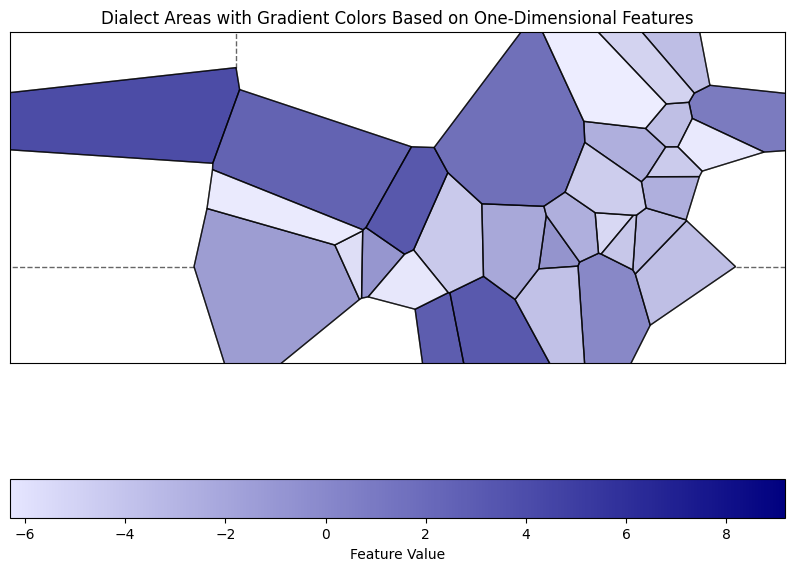

In [ ]:
plot_voronoi_with_gradient(dialect_info_df, tone2vec_1d)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


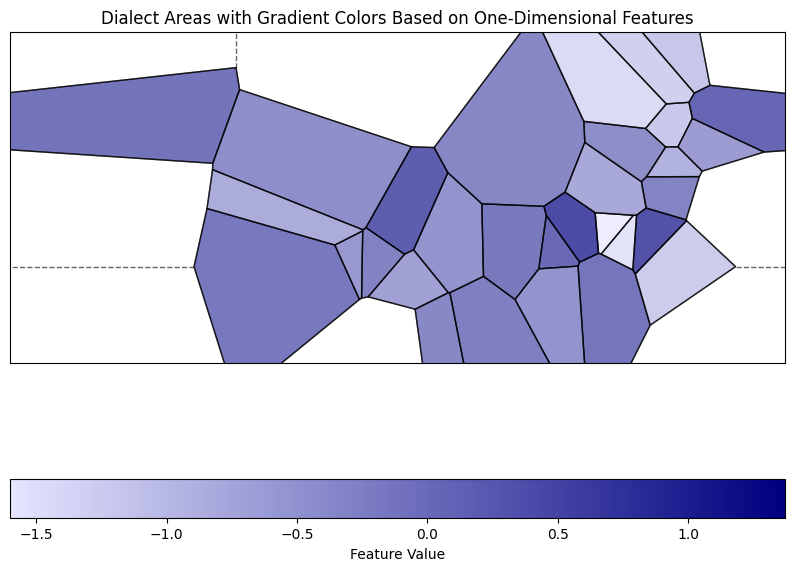

In [ ]:
plot_voronoi_with_gradient(dialect_info_df, category_1d)

# **2. Tone Transcription**

## **2.1 Model, Split, Train and Eval.**

In [ ]:
#Define the model. the model with 3 channels. from [0,1]
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class VGG16(nn.Module):
    def __init__(self, pretrained=True, normalize_values=True, gating=True, classes=3):
        super(VGG16, self).__init__()

        if pretrained:
            self.vgg = models.vgg16(pretrained=True)
        else:
            self.vgg = models.vgg16(pretrained=False)

        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1))
        self.normalize_values = normalize_values  # Add normalize_values as an instance variable
        self.gating = gating

        num_ftrs = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Identity()  # Or keep it as a feature extractor

        self.classifier_values = nn.Linear(num_ftrs, classes)  # For the three values
        self.sigmoid = nn.Sigmoid()  # Sigmoid for probability

    def forward(self, x):
        x = self.vgg(x)  # Pass through VGG

        values = self.classifier_values(x)  # Compute values
        if self.normalize_values:
            # Normalize values to [0, 1] then scale to [1, 5]
            values = torch.sigmoid(values)

        return values

class ResNet18(nn.Module):
    def __init__(self, pretrained=True, normalize_values=True, classes=3):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        self.normalize_values = normalize_values

        # Modify the first layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Modify the last layer to output 'num_classes' classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.classifier_values = nn.Linear(num_ftrs, classes)  # For the three values

        self.sigmoid = nn.Sigmoid()  # Sigmoid for probability

    def forward(self, x):
        x = self.resnet(x)

        values = self.classifier_values(x)  # Compute values
        if self.normalize_values:
            values = torch.sigmoid(values)

        return values

class DenseNet121(nn.Module):
    def __init__(self, pretrained=True, normalize_values=True, classes=3):
        super(DenseNet121, self).__init__()
        self.densenet = models.densenet121(pretrained=pretrained)
        self.normalize_values = normalize_values

        # Modify the first layer to accept single-channel input
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Modify the classifier to output 'num_classes' classes
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()

        self.classifier_values = nn.Linear(num_ftrs, classes)  # For the three values

        self.sigmoid = nn.Sigmoid()  # Sigmoid for probability

    def forward(self, x):
        features = self.densenet.features(x)
        out = F.relu(features)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)

        values = self.classifier_values(out)  # Compute values
        if self.normalize_values:
            # Normalize values to [0, 1] then scale to [1, 5]
            values = torch.sigmoid(values)

        return values

In [ ]:
import os
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch
from random import sample

def select_region(region_list, num=7):

    train_regions = sample(region_list, num)
    test_regions = [region for region in region_list if region not in train_regions]
    valid_regions = sample(test_regions, 2)
    test_regions = [region for region in test_regions if region not in valid_regions]

    print("Training Regions:")
    print(", ".join(train_regions))
    print("\n Valid Regions:")
    print(", ".join(valid_regions))
    print("\n Test Regions:")
    print(", ".join(test_regions))

    return train_regions, valid_regions, test_regions

def select_region_list(dict_dialect, region_list, train_region=False, valid_region=False, test_region=False, type="Chosen", num=7):

  if type == "Chosen" and train_region and valid_region and test_region:

    train_regions = [region for region in train_region]
    valid_regions = [region for region in valid_region]
    test_regions =  [region for region in test_region]

    print("Training Regions:")
    print(", ".join(train_regions))
    print("\n Valid Regions:")
    print(", ".join(valid_regions))
    print("\n Test Regions:")
    print(", ".join(test_regions))

  else:
    train_regions, valid_regions, test_regions = select_region(region_list, num=num)

  train_selected, valid_selected, test_selected = [], [], []

  print("\n")

  for area in train_regions:
    train_selected.extend(dict_dialect[area])
  k = len(train_regions)
  print(f"Train Selected {k} regions with: {len(train_selected)} elements")

  for area in valid_regions:
    valid_selected.extend(dict_dialect[area])
  k = len(valid_regions)
  print(f"Valid Selected {k} regions with: {len(valid_selected)} elements")

  for area in test_regions:
    test_selected.extend(dict_dialect[area])
  k = len(test_regions)
  print(f"Test Selected {k} regions with: {len(test_selected)} elements")

  print("\n")

  return train_selected, valid_selected, test_selected

In [ ]:
import os
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_and_evaluate(model, train_loader, valid_loader, optimizer, device, num_epochs, save_dir, unique_transcription, print_interval):
    """
    Train the model on the training set and select the best performing model on the validation set.

    Args:
    - model: The neural network model to train.
    - train_loader: DataLoader for the training dataset.
    - valid_loader: DataLoader for the validation dataset.
    - optimizer: Optimizer for updating the model parameters.
    - device: Device to run the training on (e.g., 'cpu' or 'cuda').
    - num_epochs: Number of training epochs.
    - save_dir: Directory to save the best model and training logs.
    - unique_transcription: Tensor containing unique transcriptions for evaluation.
    - print_interval: int, interval for printing the logs.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    log_file_path = os.path.join(save_dir, 'training_log.txt')
    unique_transcription = unique_transcription.to(device)
    criterion = nn.L1Loss()

    with open(log_file_path, 'w') as log_file:
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
        best_valid_accuracy = 0

        for epoch in range(num_epochs):
            model.train()
            train_loss_accum = 0

            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                values = model(batch_X)
                loss = criterion(values, batch_y)
                loss.backward()
                optimizer.step()
                train_loss_accum += loss.item()

            scheduler.step()
            log_file.write(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss_accum / len(train_loader):.4f}\n')

            model.eval()
            train_correct, valid_correct = 0, 0

            with torch.no_grad():
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    values = model(batch_X)
                    train_correct += eval_metric(values, batch_y, unique_transcription, metric_type='acc')

                for batch_X, batch_y in valid_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    values = model(batch_X)
                    valid_correct += eval_metric(values, batch_y, unique_transcription, metric_type='acc')

            valid_accuracy = valid_correct / len(valid_loader.dataset)
            train_accuracy = train_correct / len(train_loader.dataset)

            log_file.write(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}\n')

            if (epoch + 1) % print_interval == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}\n')

            if valid_accuracy > best_valid_accuracy:
                best_valid_accuracy = valid_accuracy
                best_model_path = os.path.join(save_dir, 'best_model.pth')
                torch.save(model.state_dict(), best_model_path)
                log_file.write(f"Saved Best Model at Epoch {epoch+1} with Valid Accuracy: {best_valid_accuracy:.4f}\n")

            log_file.flush()

In [ ]:
import os
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

def testing(model, test_feat, test_label, unique_transcription, checkpoint_dir, device):
    """
    Evaluate the model on the test set.

    Args:
    - model: The neural network model to train.
    """

    best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
    model_state_dict = torch.load(best_model_path, map_location=device)
    model.load_state_dict(model_state_dict)

    unique_transcription = unique_transcription.to(device)

    model.eval()
    with torch.no_grad():
        feats, labels = test_feat.to(device), test_label.to(device)
        values = model(feats)

        accuracy = eval_metric(values, labels, unique_transcription, metric_type='acc')
        loss   = eval_metric(values, labels, unique_transcription, metric_type='mae')

        return accuracy/test_feat.shape[0], loss/test_feat.shape[0]


def eval_metric(values, batch_y, unique_transcription, metric_type='acc'):
    """
    Calculate the accuracy or MAE of the predictions.

    Args:
    - values: torch.tensor of shape (batch_size, 3), the predicted values.
    - batch_y: torch.tensor of shape (batch_size, 3), the true labels.
    - unique_transcription: torch.tensor of shape (n, 3), the tensor containing unique transcriptions.
    - metric_type: str, the type of metric to calculate ('acc' for accuracy, 'mae' for mean absolute error).

    Returns:
    - int or float, the calculated metric (number of correct predictions for accuracy, total MAE for mean absolute error).
    """
    correct = 0
    total_loss = 0.0

    for index in range(batch_y.size(0)):
        signal = batch_y[index]
        value = values[index]
        pred_seq = match_transcription(value, unique_transcription)

        with torch.no_grad():
            if torch.sum(torch.abs(pred_seq - signal)) < 1e-2:
                correct += 1
            total_loss += torch.sum(torch.abs(pred_seq - signal))

    if metric_type == 'acc':
        return correct
    elif metric_type == 'mae':
        return total_loss

## **2.2 Loading Data and Preprocessing**

In [ ]:
import torch

def normalization_label(Y, use_sigmoid = True):
    """
    Normalize the labels in the range [0, 1]

    Args:
      Y: torch.tensor[num_samples, 3]

    Returns:
      normalized_Y: torch.tensor[num_samples, 3
    """
    normalize_Y = torch.zeros((Y.shape[0], Y.shape[1]))

    for i in range(Y.shape[0]):
        if Y[i][-1] == 0:
          normalize_Y[i][0], normalize_Y[i][1], normalize_Y[i,2] = Y[i][0], 0.5*Y[i][0] + 0.5*Y[i][1], Y[i][1]
        else:
          normalize_Y[i][0], normalize_Y[i][1], normalize_Y[i,2] = Y[i][0], Y[i][1], Y[i][2]

        min_value = normalize_Y[i].min()
        max_value = normalize_Y[i].max()
        if min_value != max_value:
            normalize_Y[i] = (normalize_Y[i] - min_value) / (max_value - min_value)
        else:
            normalize_Y[i][0], normalize_Y[i][1], normalize_Y[i,2] = 1, 1, 1

    if use_sigmoid:
        normalize_Y = torch.sigmoid(normalize_Y)

    return normalize_Y


def all_normalization_seq(use_sigmoid=True):
    """
    Generate and normalize all potential sequences, and identify unique sequences.

    Returns:
        index_list: List of lists, where each sublist contains the original sequences
                    that correspond to a unique normalized sequence.
        unique_rows: torch.tensor, unique normalized sequences.
    """
    num_sequences = 150
    all_seq = torch.zeros((num_sequences, 3))
    all_seq_str = []

    flag = 0
    for i in range(1, 6):
        for j in range(1, 6):
            all_seq_str.append([i, j])
            all_seq[flag] = torch.tensor([i, 0.5 * i + 0.5 * j, j])
            flag += 1
            for k in range(1, 6):
                all_seq_str.append([i, j, k])
                all_seq[flag] = torch.tensor([i, j, k])
                flag += 1

    # Normalize all sequences
    normalize_all_seq = normalization_label(Y=all_seq, use_sigmoid=False)

    # Find unique rows and their indices
    unique_rows, inverse_indices = torch.unique(normalize_all_seq, dim=0, return_inverse=True)
    index_list = [[] for _ in range(len(unique_rows))]

    for idx, unique_idx in enumerate(inverse_indices):
        index_list[unique_idx].append(all_seq_str[idx])

    return index_list, unique_rows


def match_transcription(feat, unique_transcription):
    """
    Matches the given feature vector to the closest row in the unique transcription tensor.

    Args:
    - feat: torch.tensor of shape (3), the feature vector to match.
    - unique_transcription: torch.tensor of shape (37, 3), the tensor containing unique transcriptions.

    Returns:
    - torch.tensor of shape (3), the closest matching row from unique_transcription.
    """

    # Compute the absolute difference between feat and each row in unique_transcription
    diff = torch.abs(unique_transcription - feat)

    # Sum the absolute differences along the second dimension to get a single value for each row
    diff_sum = diff.sum(dim=1)

    # Find the index of the row with the smallest sum of differences
    min_index = torch.argmin(diff_sum)

    # Return the row from unique_transcription that has the smallest difference
    return unique_transcription[min_index]

In [ ]:
file_path = '...'
save_path = '...'
save_path_yubao= '...'
Simi_Qua = torch.load(file_path)

loaded_data = torch.load(save_path)

loaded_dict_dialect = loaded_data["dict_dialect"]
loaded_dict_character = loaded_data["dict_character"]
loaded_dict_speaker = loaded_data["dict_speaker"]
X = loaded_data["X"]
# print(type(X))
with open(save_path_yubao, 'rb') as file:
    data_loaded = pickle.load(file)


X_tone_perfect = torch.tensor(data_loaded['mfccs_np'].reshape(-1,1,60,40).astype(np.float64),dtype=torch.float) #for mlp use

Y = loaded_data["Y"]

# print("Loaded dict_dialect:", loaded_dict_dialect.keys())
# print("Loaded dict_character:", loaded_dict_character.keys())
# print("Loaded dict_speaker:", loaded_dict_speaker.keys())
# print("Shape of loaded X:", X.shape)
# print("Shape of loaded Y:", Y.shape)

# Input Feature: X torch.Size([2236, 1, 60, 40])
# Label Y: torch.Size([2236, 3]) -> 1833(2), 403(3)
# Label Y_: torch.Size([2236, 3])

Y_ = normalization_label(Y)
# indexs_transcription: List[List[int]], unique_transcription: torch.zeros((37, 3))
indexs_transcription, unique_transcription = all_normalization_seq()

category_Y = torch.zeros(Y_.shape[0])
for index in range(Y_.shape[0]):
  diff = torch.abs(unique_transcription - Y_[index])
  diff_sum = diff.sum(dim=1)
  category_Y[index] = torch.argmin(diff_sum)
# print(len(unique_transcription))

In [ ]:
region_list = ['yancheng', 'taizhou', 'wuhu', 'dongtai', 'dafeng', 'huanggang', 'yangzhou', 'nanjing', 'hefei', 'anqing', 'jiujiang']
train_selected_1, valid_selected_1, test_selected_1 = select_region_list(loaded_dict_dialect, region_list, train_region=False, valid_region=False, test_region=False, type="Random", num=7)
train_selected_2, valid_selected_2, test_selected_2 = select_region_list(loaded_dict_dialect, region_list, train_region=False, valid_region=False, test_region=False, type="Random", num=7)
train_selected_3, valid_selected_3, test_selected_3 = select_region_list(loaded_dict_dialect, region_list, train_region=False, valid_region=False, test_region=False, type="Random", num=7)

train_selected = [train_selected_1, train_selected_2, train_selected_3]
valid_selected = [valid_selected_1, valid_selected_2, valid_selected_3]
test_selected = [test_selected_1, test_selected_2, test_selected_3]

Training Regions:
wuhu, dongtai, hefei, huanggang, yangzhou, anqing, jiujiang

 Valid Regions:
taizhou, dafeng

 Test Regions:
yancheng, nanjing


Train Selected 7 regions with: 1476 elements
Valid Selected 2 regions with: 379 elements
Test Selected 2 regions with: 381 elements


Training Regions:
dongtai, yancheng, anqing, yangzhou, wuhu, taizhou, nanjing

 Valid Regions:
huanggang, hefei

 Test Regions:
dafeng, jiujiang


Train Selected 7 regions with: 1323 elements
Valid Selected 2 regions with: 469 elements
Test Selected 2 regions with: 444 elements


Training Regions:
huanggang, wuhu, dafeng, hefei, nanjing, anqing, dongtai

 Valid Regions:
taizhou, yancheng

 Test Regions:
yangzhou, jiujiang


Train Selected 7 regions with: 1413 elements
Valid Selected 2 regions with: 383 elements
Test Selected 2 regions with: 440 elements




## **2.3 Training**

### **2.3.1 Our Methods**

In [ ]:
import os
import torch
import torch.optim as optim
def auto_parser(ACCss, LOSSss, best_lrs):
    average_acc, avaergae_loss = 0., 0.
    for index in range(len(ACCss)):

        average_acc += max(ACCss[index]) / len(ACCss)
        avaergae_loss += min(LOSSss[index]) / len(ACCss)
    return average_acc, avaergae_loss

def grid_search(model_type, lr_list, save_dir, train_loader, valid_loader, test_feat, test_label, unique_transcription, device):
    """
    Perform grid search for the best learning rate for the given model.

    Args:
    - model_type: str, type of the model to use (e.g., 'DenseNet').
    - lr_list: List[float], list of learning rates to test.
    - save_dir: str, directory to save the best model and training logs.
    - train_loader: DataLoader, training data loader.
    - valid_loader: DataLoader, validation data loader.
    - test_feat: torch.tensor, test features.
    - test_label: torch.tensor, test labels.
    - unique_transcription: torch.tensor, unique transcriptions.
    - device: torch.device, device to run the training on.

    Returns:
    - ACCs: List[float], list of accuracies for each learning rate.
    - LOSSs: List[float], list of losses for each learning rate.
    - best_lr: float, the best learning rate based on the highest accuracy.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if model_type == "DenseNet":
        model = DenseNet121().to(device)
    elif model_type == "VGG":
        model = VGG16().to(device)
    elif model_type == "ResNet":
        model = ResNet18().to(device)

    ACCs, LOSSs = [], []
    best_acc = -1
    best_lr = None

    for lr in lr_list:
        optimizer = optim.Adam(model.parameters(), lr=lr)
        save_dir_lr = os.path.join(save_dir, f"lr_{lr}")

        if not os.path.exists(save_dir_lr):
            os.makedirs(save_dir_lr)

        train_and_evaluate(
            model,
            train_loader,
            valid_loader,
            optimizer,
            device=device,
            num_epochs=100,
            save_dir=save_dir_lr,
            unique_transcription=unique_transcription,
            print_interval=10
        )

        acc, loss = testing(
            model=model,
            test_feat=test_feat,
            test_label=test_label,
            unique_transcription=unique_transcription,
            checkpoint_dir=save_dir_lr,
            device=device
        )

        ACCs.append(acc)
        LOSSs.append(loss)

        if acc > best_acc:
            best_acc = acc
            best_lr = lr

    print(f"For this dialect, the best Learning Rate is {best_lr}, Test Accuracy: {acc:.4f}")

    return ACCs, LOSSs, best_lr

In [ ]:
#DenseNet Model tone transcription test.
#[0.001, 0.005, 0.01]
save_dir = '...'

ACCss, LOSSss, best_lrs = [], [], []
for dialect_index in range(len(train_selected)):
    train_selected_dialect = train_selected[dialect_index]
    valid_selected_dialect = valid_selected[dialect_index]
    test_selected_dialect = test_selected[dialect_index]

    x_train, x_valid, x_test = X[train_selected_dialect], X[valid_selected_dialect], X[test_selected_dialect]
    y_train, y_valid, y_test = Y_[train_selected_dialect], Y_[valid_selected_dialect], Y_[test_selected_dialect]

    train_dataset, valid_dataset, test_dataset = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid), TensorDataset(x_test, y_test)
    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    save_dir_lr = os.path.join(save_dir, f"dialect_{dialect_index}")
    lr_list = [0.005, 0.001, 0.0005, 0.0001, 0.00005]

    ACCs, LOSSs, best_lr = grid_search("DenseNet", lr_list, save_dir_lr, train_loader, valid_loader, x_test, y_test, unique_transcription, device)
    ACCss.append(ACCs)
    LOSSss.append(LOSSs)
    best_lrs.append(best_lr)

In [ ]:
average_acc, average_loss = auto_parser(ACCss, LOSSss, best_lrs)
file_path = '...'
with open(file_path, 'a') as file:
    file.write(f'{average_acc}, {average_loss}\n')

In [ ]:
#ResNet Model tone transcription test.
#[0.001, 0.005, 0.01]
save_dir = '...'

ACCss, LOSSss, best_lrs = [], [], []
for dialect_index in range(len(train_selected)):
    train_selected_dialect = train_selected[dialect_index]
    valid_selected_dialect = valid_selected[dialect_index]
    test_selected_dialect = test_selected[dialect_index]

    x_train, x_valid, x_test = X[train_selected_dialect], X[valid_selected_dialect], X[test_selected_dialect]
    y_train, y_valid, y_test = Y_[train_selected_dialect], Y_[valid_selected_dialect], Y_[test_selected_dialect]

    train_dataset, valid_dataset, test_dataset = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid), TensorDataset(x_test, y_test)
    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    save_dir_lr = os.path.join(save_dir, f"dialect_{dialect_index}")
    lr_list = [0.005, 0.001, 0.0005, 0.0001, 0.00005]

    ACCs, LOSSs, best_lr = grid_search("ResNet", lr_list, save_dir_lr, train_loader, valid_loader, x_test, y_test, unique_transcription, device)
    ACCss.append(ACCs)
    LOSSss.append(LOSSs)
    best_lrs.append(best_lr)

average_acc, average_loss = auto_parser(ACCss, LOSSss, best_lrs)
file_path = '...'
with open(file_path, 'a') as file:
    file.write(f'{average_acc}, {average_loss}\n')

In [ ]:
#VGG Model tone transcription test.
#
save_dir = '...'

ACCss, LOSSss, best_lrs = [], [], []
for dialect_index in range(len(train_selected)):
    train_selected_dialect = train_selected[dialect_index]
    valid_selected_dialect = valid_selected[dialect_index]
    test_selected_dialect = test_selected[dialect_index]

    x_train, x_valid, x_test = X[train_selected_dialect], X[valid_selected_dialect], X[test_selected_dialect]
    y_train, y_valid, y_test = Y_[train_selected_dialect], Y_[valid_selected_dialect], Y_[test_selected_dialect]

    train_dataset, valid_dataset, test_dataset = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid), TensorDataset(x_test, y_test)
    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    save_dir_lr = os.path.join(save_dir, f"dialect_{dialect_index}")
    lr_list = [0.005, 0.001, 0.0005, 0.0001, 0.00005]

    ACCs, LOSSs, best_lr = grid_search("VGG", lr_list, save_dir_lr, train_loader, valid_loader, x_test, y_test, unique_transcription, device)
    ACCss.append(ACCs)
    LOSSss.append(LOSSs)
    best_lrs.append(best_lr)

average_acc, average_loss = auto_parser(ACCss, LOSSss, best_lrs)
file_path = '...'
with open(file_path, 'a') as file:
    file.write(f'{average_acc}, {average_loss}\n')

### **2.3.1.1 Demo Test**

In [ ]:
average_acc, avaergae_loss = auto_parser(ACCss, LOSSss, best_lrs)

print(average_acc, avaergae_loss)

0.9744580837100523 tensor(0.1172, device='cuda:0')


In [ ]:
#Checking show the output：

best_model_path = os.path.join('...', 'best_model.pth')
model_state_dict = torch.load(best_model_path, map_location=device)
model = DenseNet121().to(device)
model.load_state_dict(model_state_dict)
unique_transcription = unique_transcription.to(device)

train_selected_dialect = train_selected[0]
valid_selected_dialect = valid_selected[0]
test_selected_dialect = test_selected[0]

x_train, x_valid, x_test = X[train_selected_dialect], X[valid_selected_dialect], X[test_selected_dialect]
y_train, y_valid, y_test = Y_[train_selected_dialect], Y_[valid_selected_dialect], Y_[test_selected_dialect]

train_dataset, valid_dataset, test_dataset = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid), TensorDataset(x_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.eval()
with torch.no_grad():
    feats, labels = x_test.to(device), y_test.to(device)
    values = model(feats)
    print(values.shape)

    for index in range(labels.size(0)):
        signal = labels[index]
        value = values[index]
        pred_seq = match_transcription(value, unique_transcription)
        print((pred_seq - signal).cpu().numpy())



### **2.3.3 F0 Baseline**

In [ ]:
import pickle

input_file_path = ".../trans_labels.pkl"
with open(input_file_path, 'rb') as file:
    trans, labels = pickle.load(file)

print("Trans:", trans)
print("Labels:", labels)

Trans: [[143.84275319403736, 120.97303737277609, 115.80885569899833], [175.9528305748717, 162.58785425367472, 151.15113116850642], [204.48284193353487, 185.24025718065155, 106.2498732780014], [229.0675794746981, 251.31678778339887, 239.52180403798747], [271.5911774339172, 266.6041879955109, 248.72712912698444], [201.41903295360515, 192.52745152954034, 193.9657478327627], [262.42049562993515, 228.23392898396642, 134.3481191102795], [146.49563768218744, 114.25535732989763, 122.4071884304203], [225.55025403613107, 217.9250460283356, 203.26550255518907], [139.17568916025863, 126.76142853998367, 131.8866207377009], [128.10995780388814, 102.81833390593363, 105.14815538725429], [274.78706218496325, 212.3288206538757, 100.78362075239498], [193.48750842701475, 190.2728712357576, 97.18461827933965], [212.1891612930575, 166.7925706711514, 120.81932060560183], [266.5994211220884, 193.33868829402542, 148.9294815072865], [194.64555857734723, 172.65955133825742, 164.26446824119003], [443.675768531781

In [ ]:
import torch

def compare_f0(f0_list, label_lists, unique_transcription):

    num, acc, loss = 0, 0, 0
    for index in range(len(f0_list)):
      f0_pred, label = f0_list[index], label_lists[index]
      min_value, max_value = min(f0_pred), max(f0_pred)
      f0_pred_torch = torch.tensor((f0_pred - min_value) / (max_value - min_value))
      normalize_pred = torch.sigmoid(f0_pred_torch)
      normalize_pred = match_transcription(normalize_pred, unique_transcription)

      label_list = [float(label_) for label_ in label]
      if len(label_list) == 2:
        label_torch = torch.tensor([label_list[0], 0.5*label_list[0]+0.5*label_list[1], label_list[1]])
        min_value, max_value = min(label_torch), max(label_torch)
        label_torch = (label_torch - min_value) / (max_value - min_value)
        normalize_label = torch.sigmoid(label_torch)
        normalize_label = match_transcription(normalize_label, unique_transcription)

        num += 1
        loss += torch.sum(torch.abs(normalize_label - normalize_pred))
        if torch.sum(torch.abs(normalize_label - normalize_pred)) < 1e-5:
          acc += 1

      elif len(label_list) == 3:
        label_torch = torch.tensor([label_list[0], label_list[1], label_list[2]])
        min_value, max_value = min(label_torch), max(label_torch)
        label_torch = (label_torch - min_value) / (max_value - min_value)
        normalize_label = torch.sigmoid(label_torch)
        normalize_label = match_transcription(normalize_label, unique_transcription)
        num += 1

        loss += torch.sum(torch.abs(normalize_label - normalize_pred))
        if torch.sum(torch.abs(normalize_label - normalize_pred)) < 1e-5:
          acc += 1

    return acc, num, loss


In [ ]:
acc, num, loss = compare_f0(trans, labels, unique_transcription)

In [ ]:
unique_transcription[6]

tensor([0.5000, 0.7311, 0.5000], device='cuda:0')

In [ ]:
unique_transcription[3]

tensor([0.5000, 0.6225, 0.7311], device='cuda:0')

In [ ]:
indexs_transcription[11]

[[1, 5, 4]]

In [ ]:
diff_matrix = torch.zeros((unique_transcription.shape[0], unique_transcription.shape[0]))
for i in range(unique_transcription.shape[0]):
  for j in range(unique_transcription.shape[0]):
    diff_matrix[i, j] = torch.sum(torch.abs(unique_transcription[i] - unique_transcription[j]))

# **3. Tone Clutsering**

## **3.1 Demo: Automatic Clustering**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class DenseNet(nn.Module):
    def __init__(self, k, pretrained=True, normalize_values=True, classes=3):
        super(DenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=pretrained)
        self.normalize_values = normalize_values

        # Modify the first layer to accept k-channel input
        self.densenet.features.conv0 = nn.Conv2d(k, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Modify the classifier to output 'classes' classes
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()

        self.classifier_values = nn.Linear(num_ftrs, classes)  # For the three values

        self.sigmoid = nn.Sigmoid()  # Sigmoid for probability

    def forward(self, x):
        features = self.densenet.features(x)
        out = F.relu(features)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)

        values = self.classifier_values(out)  # Compute values
        if self.normalize_values:
            # Normalize values to [0, 1] then scale to [1, 5]
            values = F.softmax(values, dim=1)

        return values  # Remove squeeze(0) to maintain batch dimension

In [ ]:
import torch

def normalization_label_cluster(Y):
    """
    Args:
      Y: torch.tensor[num_samples, 3]

    Returns:
      normalized_Y: torch.tensor[num_samples, 3
    """
    normalize_Y = torch.zeros((Y.shape[0], Y.shape[1]))

    for i in range(Y.shape[0]):
        if Y[i][-1] == 0:
          normalize_Y[i][0], normalize_Y[i][1], normalize_Y[i,2] = Y[i][0], 0.5*Y[i][0] + 0.5*Y[i][1], Y[i][1]
        else:
          normalize_Y[i][0], normalize_Y[i][1], normalize_Y[i,2] = Y[i][0], Y[i][1], Y[i][2]

    return normalize_Y


def all_normalization_seq_cluster():
    """
    Generate and normalize all potential sequences, and identify unique sequences.

    Returns:
        index_list: List of lists, where each sublist contains the original sequences
                    that correspond to a unique normalized sequence.
        unique_rows: torch.tensor, unique normalized sequences.
    """
    num_sequences = 150
    all_seq = torch.zeros((num_sequences, 3))
    all_seq_str = []

    flag = 0
    for i in range(1, 6):
        for j in range(1, 6):
            all_seq_str.append([i, j])
            all_seq[flag] = torch.tensor([i, 0.5 * i + 0.5 * j, j])
            flag += 1
            for k in range(1, 6):
                if (i - j) * (j - k) < 0: #三个只保留曲折调
                  all_seq_str.append([i, j, k])
                  all_seq[flag] = torch.tensor([i, j, k])
                  flag += 1

    return all_seq_str, all_seq[:flag]


def match_transcription(feat, unique_transcription):
    """
    Matches the given feature vector to the closest row in the unique transcription tensor.

    Args:
    - feat: torch.tensor of shape (3), the feature vector to match.
    - unique_transcription: torch.tensor of shape (37, 3), the tensor containing unique transcriptions.

    Returns:
    - torch.tensor of shape (3), the closest matching row from unique_transcription.
    """

    # Compute the absolute difference between feat and each row in unique_transcription
    diff = torch.abs(unique_transcription - feat)

    # Sum the absolute differences along the second dimension to get a single value for each row
    diff_sum = diff.sum(dim=1)

    # Find the index of the row with the smallest sum of differences
    min_index = torch.argmin(diff_sum)

    # Return the row from unique_transcription that has the smallest difference
    return unique_transcription[min_index]

In [ ]:
# 构建concat X
import random
import torch

def find_sample_dict(region_dict, speaker_dict, concat_num, N):
    """
    Create a dictionary with samples from region_dict and speaker_dict.

    Parameters:
    region_dict (dict): Dictionary with regions as keys and lists of indices as values.
    speaker_dict (dict): Dictionary with speakers as keys and lists of indices as values.
    concat_num (int): Number of elements to concatenate.
    N: Input shape.

    Returns:
    dict: Dictionary with indices as keys and lists of concatenated samples as values.
    """

    sample_dict = {i: [] for i in range(N)}

    for region_key, region_list in region_dict.items():
        for region_index in region_list:
            for speaker_key, speaker_list in speaker_dict.items():
                if region_index in speaker_list:
                    # Find common elements between region_list and speaker_list
                    common_indices = list(set(region_list).intersection(set(speaker_list)))
                    # Randomly select elements with replacement
                    random_elements = random.choices(common_indices, k=concat_num - 1)
                    # Concatenate the region_index with the random elements
                    sample_dict[region_index] = [region_index] + random_elements

    return sample_dict

def concat_features(X, concat_dict):

  X_concat = torch.zeros((X.shape[0], len(concat_dict[0]), X.shape[2], X.shape[3]))
  for index in range(X.shape[0]):
    for i in range(len(concat_dict[index])):
      X_concat[index][i] = X[concat_dict[index][i]][0]

  return X_concat


In [ ]:
def grid_search_clustering(model_type, k, lr_list, save_dir, train_loader, valid_loader, test_feat, test_label, unique_transcription, device):
    """
    Perform grid search for the best learning rate for the given model.

    Args:
    - model_type: str, type of the model to use (e.g., 'DenseNet').
    - lr_list: List[float], list of learning rates to test.
    - save_dir: str, directory to save the best model and training logs.
    - train_loader: DataLoader, training data loader.
    - valid_loader: DataLoader, validation data loader.
    - test_feat: torch.tensor, test features.
    - test_label: torch.tensor, test labels.
    - unique_transcription: torch.tensor, unique transcriptions.
    - device: torch.device, device to run the training on.

    Returns:
    - ACCs: List[float], list of accuracies for each learning rate.
    - LOSSs: List[float], list of losses for each learning rate.
    - best_lr: float, the best learning rate based on the highest accuracy.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if model_type == "DenseNet":
        model = DenseNet(k=k, pretrained=True, normalize_values=False, classes=3).to(device)
    elif model_type == "VGG":
        model = VGG16().to(device)
    elif model_type == "ResNet":
        model = ResNet18().to(device)

    ACCs, LOSSs = [], []
    best_acc = -1
    best_lr = None

    for lr in lr_list:
        optimizer = optim.Adam(model.parameters(), lr=lr)
        save_dir_lr = os.path.join(save_dir, f"lr_{lr}")

        if not os.path.exists(save_dir_lr):
            os.makedirs(save_dir_lr)

        train_and_evaluate(
            model,
            train_loader,
            valid_loader,
            optimizer,
            device=device,
            num_epochs=40,
            save_dir=save_dir_lr,
            unique_transcription=unique_transcription,
            print_interval=5
        )

        acc, loss = testing(
            model=model,
            test_feat=test_feat,
            test_label=test_label,
            unique_transcription=unique_transcription,
            checkpoint_dir=save_dir_lr,
            device=device
        )

        ACCs.append(acc)
        LOSSs.append(loss)

        if acc > best_acc:
            best_acc = acc
            best_lr = lr

    print(f"For this dialect, the best Learning Rate is {best_lr}, Test Accuracy: {acc:.4f}")

    return ACCs, LOSSs, best_lr

In [ ]:
region_list = ['yancheng', 'taizhou', 'wuhu', 'dongtai', 'dafeng', 'huanggang', 'yangzhou', 'nanjing', 'hefei', 'anqing', 'jiujiang']
train_dialect = ["huanggang", "taizhou", "dongtai", "yancheng", "jiujiang", "anqing", "hefei"]
valid_dialect = ["dafeng", "nanjing"]
test_dialect = ["wuhu", "yangzhou"]

train_selected, valid_selected, test_selected = select_region_list(loaded_dict_dialect, region_list, train_dialect, valid_dialect, test_dialect, type="Chosen", num=7)

Training Regions:
huanggang, taizhou, dongtai, yancheng, jiujiang, anqing, hefei

 Valid Regions:
dafeng, nanjing

 Test Regions:
wuhu, yangzhou


Train Selected 7 regions with: 1537 elements
Valid Selected 2 regions with: 377 elements
Test Selected 2 regions with: 322 elements




In [ ]:
train_dialect = ["huanggang", "taizhou", "dongtai", "yancheng", "jiujiang", "anqing", "hefei"]
valid_dialect = ["dafeng", "nanjing"]
test_dialect = ["wuhu", "yangzhou"]

In [ ]:
Y_cluster = normalization_label_cluster(Y)
print(Y_cluster)

tensor([[0.5065, 0.3072, 0.1863],
        [0.7856, 0.1753, 0.0391],
        [0.6652, 0.2447, 0.0900],
        ...,
        [0.6652, 0.2447, 0.0900],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]])


In [ ]:
save_dir = '...'

index_list, unique_transcription = all_normalization_seq_cluster()
concat_dict = find_sample_dict(loaded_dict_dialect, loaded_dict_speaker, 1, X.shape[0])
X_cluster = concat_features(X, concat_dict)
Y_cluster = normalization_label_cluster(Y)

ACCss, LOSSss, best_lrs = [], [], []

x_train, x_valid, x_test = X_cluster[train_selected], X_cluster[valid_selected], X_cluster[test_selected]
y_train, y_valid, y_test = Y_cluster[train_selected], Y_cluster[valid_selected], Y_cluster[test_selected]

In [ ]:
#DenseNet Model tone transcription test. (Categorical Baseline)
#[0.001, 0.005, 0.01]
save_dir = '...'

index_list, unique_transcription = all_normalization_seq_cluster()
concat_dict = find_sample_dict(loaded_dict_dialect, loaded_dict_speaker, 1, X.shape[0])
X_cluster = concat_features(X, concat_dict)
Y_cluster = normalization_label_cluster(Y)

ACCss, LOSSss, best_lrs = [], [], []

x_train, x_valid, x_test = X_cluster[train_selected], X_cluster[valid_selected], X_cluster[test_selected]
y_train, y_valid, y_test = Y_cluster[train_selected], Y_cluster[valid_selected], Y_cluster[test_selected]

train_dataset, valid_dataset, test_dataset = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid), TensorDataset(x_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=125, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=125, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=125, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir_lr = os.path.join(save_dir, f"k_{1}")
lr_list = [0.0005, 0.001, 0.0001]

ACCs, LOSSs, best_lr = grid_search_clustering("DenseNet", 1, lr_list, save_dir_lr, train_loader, valid_loader, x_test, y_test, unique_transcription, device)
ACCss.append(ACCs)
LOSSss.append(LOSSs)
best_lrs.append(best_lr)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class DenseNet_feat(nn.Module):
    def __init__(self, k, pretrained=True, normalize_values=True, classes=3):
        super(DenseNet_feat, self).__init__()
        self.densenet = models.densenet121(pretrained=pretrained)
        self.normalize_values = normalize_values

        # Modify the first layer to accept k-channel input
        self.densenet.features.conv0 = nn.Conv2d(k, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Modify the classifier to output 'classes' classes
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()

        self.classifier_values = nn.Linear(num_ftrs, classes)  # For the three values

        self.sigmoid = nn.Sigmoid()  # Sigmoid for probability

    def forward(self, x):
        features = self.densenet.features(x)
        out = F.relu(features)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)

        values = self.classifier_values(out)  # Compute values
        if self.normalize_values:
            # Normalize values using softmax
            values = F.softmax(values, dim=1)

        return values

    def get_last_layer_features(self, x):
        """
        This method returns the features from the last layer before the classifier.
        """
        x = self.densenet.features(x)
        x_flattened = x.view(x.size(0), -1)
        return x_flattened

    def get_features_by_index(self, x, layer_index):
        """
        Extract the features from a specified layer index.

        Args:
          x: Input tensor.
          layer_index: The index of the layer to extract features from.

        Returns:
          The features from the specified layer.
        """
        hooks = {}
        layers = list(self.densenet.named_modules())

        def hook(module, input, output):
            hooks[layer_index] = output

        # Register hook for the specified layer index
        layer_name, layer = layers[layer_index]
        handle = layer.register_forward_hook(hook)

        # Perform forward pass
        self.forward(x)

        # Remove hook
        handle.remove()

        return hooks[layer_index]

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap
import umap

def reduce_dim(matrix: np.ndarray, dim: int = 2, method: str = 'pca') -> np.ndarray:
    """
    Reduce the dimensionality of the given matrix using the specified method.

    Args:
    - matrix (np.ndarray): Input matrix with shape [n_samples, n_features]
    - dim (int): Target dimensionality
    - method (str): Dimensionality reduction method ('pca', 'umap', 'tsne', 'mds', 'isomap')

    Returns:
    - np.ndarray: Reduced dimension matrix with shape [n_samples, dim]
    """
    if method == 'pca':
        reducer = PCA(n_components=dim)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=dim)
    elif method == 'tsne':
        reducer = TSNE(n_components=dim)
    elif method == 'mds':
        reducer = MDS(n_components=dim, dissimilarity='euclidean')
    elif method == 'isomap':
        reducer = Isomap(n_components=dim)
    else:
        raise ValueError(f"Unsupported method: {method}. Choose from 'pca', 'umap', 'tsne', 'mds', 'isomap'.")

    reduced_matrix = reducer.fit_transform(matrix)
    return reduced_matrix

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN

def auto_cluster_feat(X, checkpoint_dir, layer_index, unique_transcription, device):
    """
    Extract features from the intermediate layers of a trained transcription model and normalize them.

    Args:
        X (torch.Tensor): Input features of shape (num_samples, feature_shape).
        checkpoint_dir (str): Directory containing the model checkpoint.
        layer_index (int): The index of the intermediate layer to extract features from.
        unique_transcription (list): List of unique transcriptions for decoding.
        device (str): Device to run the model on.

    Returns:
        tuple: Normalized embeddings and predicted sequences.
    """
    model = DenseNet_feat(k=X.shape[1], pretrained=True, normalize_values=False, classes=3).to(device)
    best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
    model_state_dict = torch.load(best_model_path, map_location=device)
    model.load_state_dict(model_state_dict)

    model.eval()
    with torch.no_grad():
        feats = X.to(device)
        values = model(feats)
        pred_seq = [match_transcription(values[index].cpu(), unique_transcription) for index in range(values.shape[0])]

        # Get the embedding
        if layer_index == -1:
            embed = model.get_last_layer_features(feats).cpu().numpy()
        else:
            embed = model.get_features_by_index(feats, layer_index).cpu().numpy()

        # Normalize the embeddings
        embed = normalize(embed)
    return embed, pred_seq

def auto_cluster_plot(embed, pred_seq, eps=0.5, min_samples=2, type_='raw'):
    """
    Clusters and visualizes the embeddings using DBSCAN.

    Args:
        embed (np.ndarray): Normalized embeddings.
        pred_seq (list): Predicted sequences.
        eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood.
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.
        type_ (str): Type of clustering to perform ('raw' or 'umap').

    Returns:
        dict: Unique class names for each cluster.
    """
    # Reduce the dimensionality for visualization
    reduced_feats = reduce_dim(matrix=embed, dim=2, method='umap')

    # Use DBSCAN for clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(embed if type_ == 'raw' else reduced_feats)
    cluster_labels = dbscan.labels_

    # Check clustering results
    print("Unique cluster labels:", np.unique(cluster_labels))

    # Count the occurrences of each transcription in each cluster
    class_names = {}
    for i, label in enumerate(pred_seq):
        label = str(label.tolist()) if isinstance(label, torch.Tensor) else label
        if cluster_labels[i] == -1:
            continue  # Skip noise points
        if cluster_labels[i] not in class_names:
            class_names[cluster_labels[i]] = [label]
        else:
            class_names[cluster_labels[i]].append(label)

    unique_class_names = {}
    while class_names:
        most_common_label, most_common_count, most_common_cluster = None, 0, None
        for cluster_label, labels in class_names.items():
            label_counts = {label: labels.count(label) for label in labels}
            common_label, common_count = max(label_counts.items(), key=lambda item: item[1])
            if common_count > most_common_count:
                most_common_label, most_common_count, most_common_cluster = common_label, common_count, cluster_label

        unique_class_names[most_common_cluster] = most_common_label

        # Remove the most common label from all clusters
        for cluster_label in list(class_names.keys()):
            if cluster_label in class_names:
                class_names[cluster_label] = [label for label in class_names[cluster_label] if label != most_common_label]
                if not class_names[cluster_label]:
                    del class_names[cluster_label]

    # Visualize clustering results
    plt.figure(figsize=(8, 8))  # Make the figure square
    for cluster_label, class_name in unique_class_names.items():
        indices = np.where(cluster_labels == cluster_label)
        plt.scatter(reduced_feats[indices, 0], reduced_feats[indices, 1], label=class_name, alpha=0.7, s=100)  # Increase marker size

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 20})  # Move legend outside the plot
    plt.title('Tone Dialect Clustering with Auto-Classification', fontsize=14)  # Increase title font size
    plt.show()

    return unique_class_names


In [ ]:
# test_dialect = ["wuhu", "yangzhou"]

group_index = list(set(loaded_dict_speaker['03']).intersection(set(loaded_dict_dialect['wuhu'])))

save_path = '...'
print(torch.unique(Y_cluster[group_index],dim=0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed, pred_seq = auto_cluster_feat(X_cluster[group_index], save_path, -1, unique_transcription, device)

tensor([[2., 1., 2.],
        [2., 3., 4.],
        [5., 3., 1.],
        [5., 5., 5.]])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unique cluster labels: [-1  0  1  2  3]


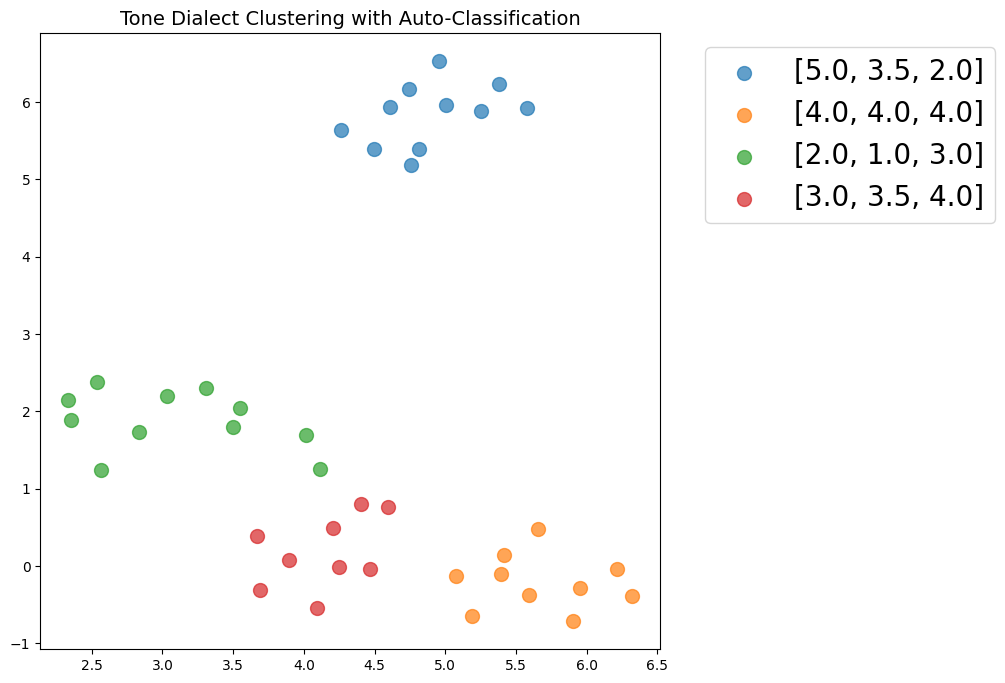

{0: '[5.0, 3.5, 2.0]',
 1: '[4.0, 4.0, 4.0]',
 2: '[2.0, 1.0, 3.0]',
 3: '[3.0, 3.5, 4.0]'}

In [ ]:
auto_cluster_plot(embed, pred_seq, device, eps=0.6, min_samples=4, type_='umap')

# [212, 24, 51, 55] type 3
# [213, 34, 52, 44]

# eps=0.5, min_samples=3


In [ ]:
group_index = list(set(loaded_dict_speaker['01']).intersection(set(loaded_dict_dialect['wuhu'])))

save_path = '...'
print(torch.unique(Y_cluster[group_index],dim=0))
embed, pred_seq = auto_cluster_feat(X_cluster[group_index], save_path, -1, unique_transcription, device)

tensor([[2.0000, 1.0000, 3.0000],
        [2.0000, 3.0000, 4.0000],
        [4.0000, 2.5000, 1.0000],
        [5.0000, 4.0000, 3.0000]])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unique cluster labels: [-1  0  1  2  3]


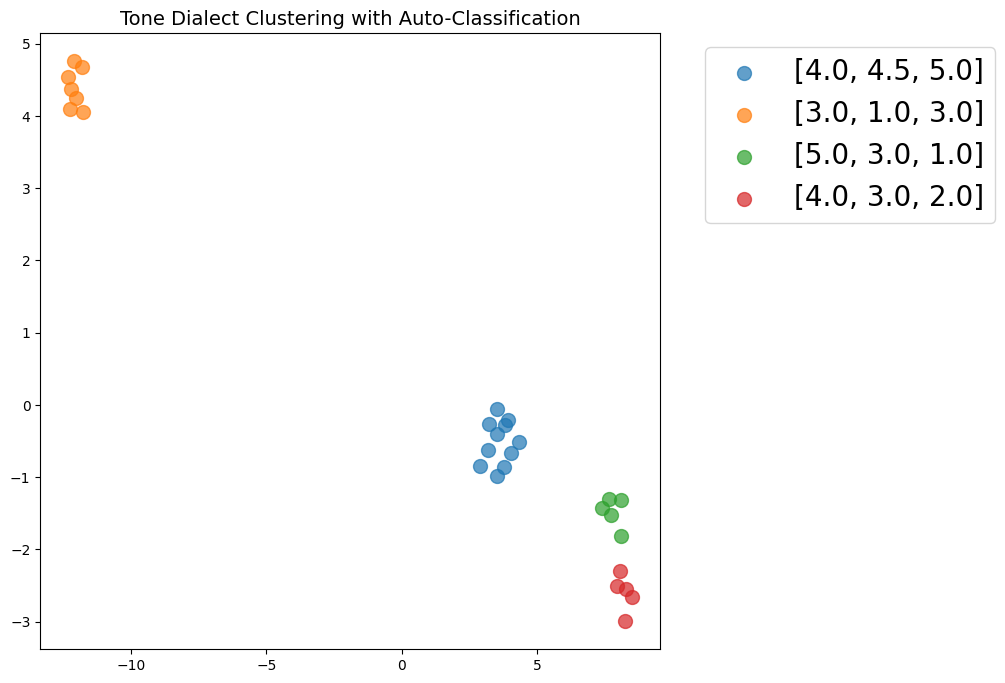

{0: '[4.0, 4.5, 5.0]',
 1: '[3.0, 1.0, 3.0]',
 2: '[5.0, 3.0, 1.0]',
 3: '[4.0, 3.0, 2.0]'}

In [ ]:
auto_cluster_plot(embed, pred_seq, device, eps=0.6, min_samples=4, type_='umap')

# [213, 24, 41, 53] type 1
# [313, 45, 51, 42]


In [ ]:
group_index = list(set(loaded_dict_speaker['02']).intersection(set(loaded_dict_dialect['wuhu'])))

save_path = '...'
print(torch.unique(Y_cluster[group_index],dim=0))
embed, pred_seq = auto_cluster_feat(X_cluster[group_index], save_path, -1, unique_transcription, device)

tensor([[2.0000, 1.0000, 3.0000],
        [2.0000, 3.0000, 4.0000],
        [4.0000, 2.5000, 1.0000],
        [5.0000, 3.0000, 1.0000]])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unique cluster labels: [-1  0  1  2  3]


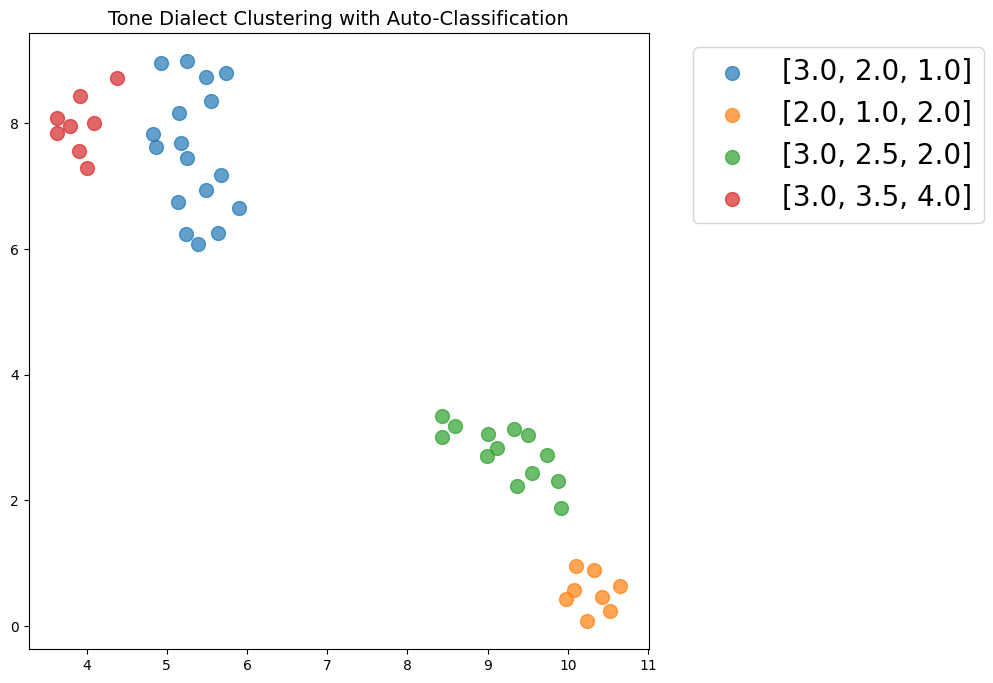

{3: '[3.0, 2.0, 1.0]',
 0: '[2.0, 1.0, 2.0]',
 1: '[3.0, 2.5, 2.0]',
 2: '[3.0, 3.5, 4.0]'}

In [ ]:
auto_cluster_plot(embed, pred_seq, device, eps=0.6, min_samples=4, type_='umap')

# [213, 24, 41, 51] type 2
# [212, 34, 31, 32]


In [ ]:
group_index = list(set(loaded_dict_speaker['04']).intersection(set(loaded_dict_dialect['yangzhou'])))

save_path = '...'
print(torch.unique(Y_cluster[group_index],dim=0))
embed, pred_seq = auto_cluster_feat(X_cluster[group_index], save_path, -1, unique_transcription, device)

tensor([[2.0000, 3.0000, 4.0000],
        [3.0000, 2.0000, 1.0000],
        [4.0000, 2.5000, 1.0000],
        [5.0000, 5.0000, 5.0000]])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unique cluster labels: [-1  0  1  2]


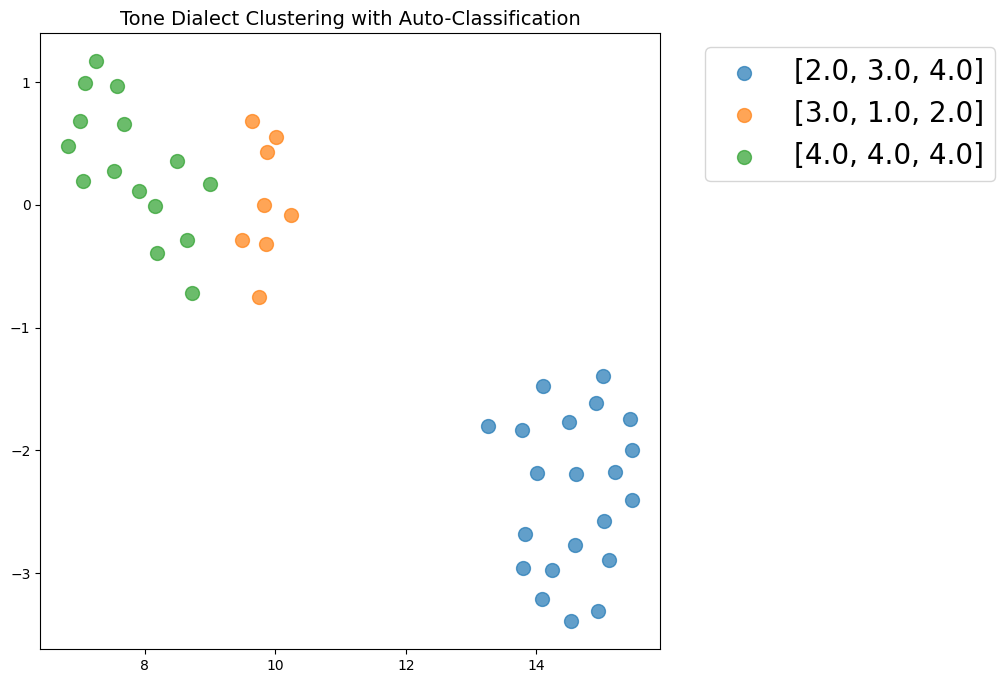

{0: '[2.0, 3.0, 4.0]', 2: '[3.0, 1.0, 2.0]', 1: '[4.0, 4.0, 4.0]'}

In [ ]:
auto_cluster_plot(embed, pred_seq, device, eps=0.6, min_samples=4, type_='umap')

# [41, 24, 31, 55] type 4
# [-, 24, 32, 44]


In [ ]:
group_index = list(set(loaded_dict_speaker['01']).intersection(set(loaded_dict_dialect['yangzhou'])))

save_path = '...'
print(torch.unique(Y_cluster[group_index],dim=0))
embed, pred_seq = auto_cluster_feat(X_cluster[group_index], save_path, -1, unique_transcription, device)

tensor([[2.0000, 3.0000, 4.0000],
        [3.0000, 2.0000, 1.0000],
        [4.0000, 2.5000, 1.0000],
        [5.0000, 5.0000, 5.0000]])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unique cluster labels: [-1  0  1  2]


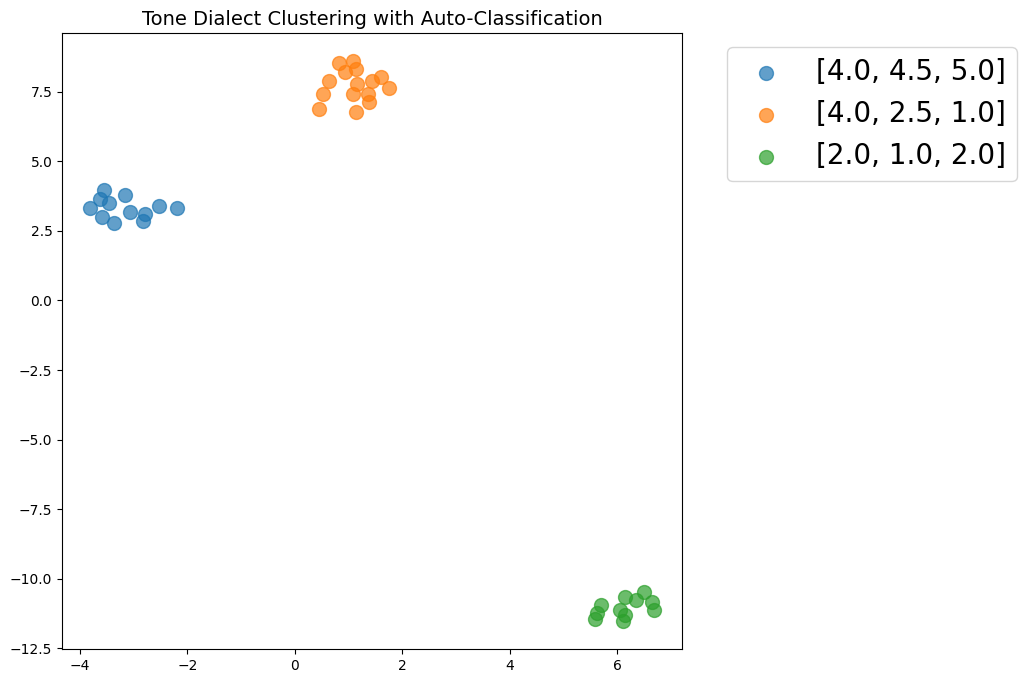

{0: '[4.0, 4.5, 5.0]', 1: '[4.0, 2.5, 1.0]', 2: '[2.0, 1.0, 2.0]'}

In [ ]:
auto_cluster_plot(embed, pred_seq, device, eps=0.6, min_samples=4, type_='umap')

# [41, 24, 31, 55] type 1
# [41, -, 212, 45]

In [ ]:
group_index = list(set(loaded_dict_speaker['03']).intersection(set(loaded_dict_dialect['yangzhou'])))

save_path = '...'
print(torch.unique(Y_cluster[group_index],dim=0))
embed, pred_seq = auto_cluster_feat(X_cluster[group_index], save_path, -1, unique_transcription, device)

tensor([[2.0000, 3.0000, 4.0000],
        [3.0000, 2.5000, 2.0000],
        [5.0000, 3.0000, 1.0000],
        [5.0000, 5.0000, 5.0000]])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unique cluster labels: [-1  0  1  2  3]


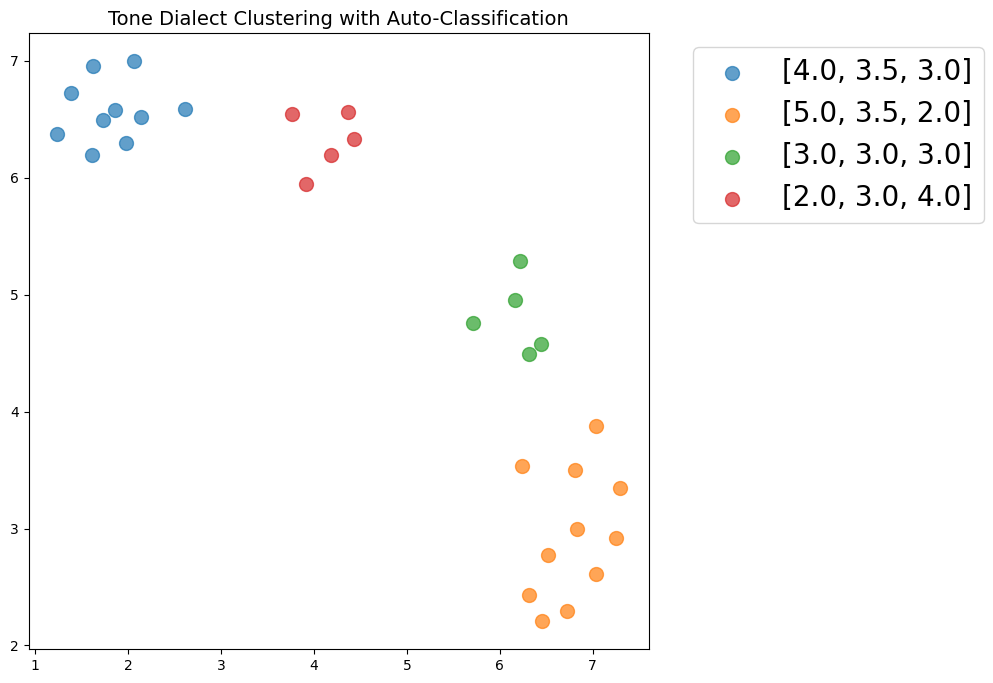

{1: '[4.0, 3.5, 3.0]',
 3: '[5.0, 3.5, 2.0]',
 2: '[3.0, 3.0, 3.0]',
 0: '[2.0, 3.0, 4.0]'}

In [ ]:
auto_cluster_plot(embed, pred_seq, device, eps=0.6, min_samples=4, type_='umap')


# [51, 24, 32, 55] type 3
# [52, 24, 43, 33]

In [ ]:
group_index = list(set(loaded_dict_speaker['02']).intersection(set(loaded_dict_dialect['yangzhou'])))

save_path = '...'
print(torch.unique(Y_cluster[group_index],dim=0))
embed, pred_seq = auto_cluster_feat(X_cluster[group_index], save_path, -1, unique_transcription, device)

tensor([[2.0000, 3.0000, 4.0000],
        [3.0000, 2.5000, 2.0000],
        [4.0000, 2.5000, 1.0000],
        [5.0000, 5.0000, 5.0000]])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unique cluster labels: [0 1 2 3]


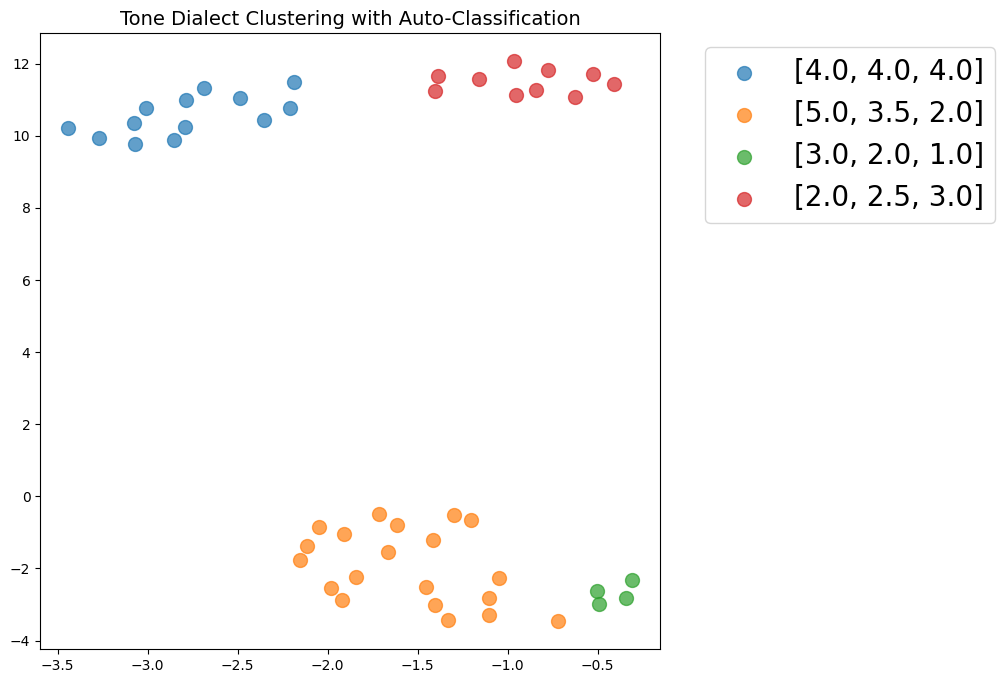

{3: '[4.0, 4.0, 4.0]',
 0: '[5.0, 3.5, 2.0]',
 1: '[3.0, 2.0, 1.0]',
 2: '[2.0, 2.5, 3.0]'}

In [ ]:
auto_cluster_plot(embed, pred_seq, device, eps=0.6, min_samples=4, type_='umap')


# [41, 24, 32, 55] type 2
# [52, 23, 31, 44]